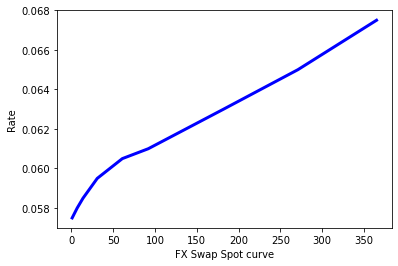

   Days   Rates
0     1  0.0575
1     7  0.0580
2    14  0.0585
3    31  0.0595
4    61  0.0605
5    92  0.0610
6   182  0.0630
7   271  0.0650
8   365  0.0675


In [1]:
#Market quotes FX Swapollas
spot_curve = [[1, 0.0575],
             [7, 0.058],
             [14, 0.0585],
             [31, 0.0595],
             [61, 0.0605],
             [92, 0.0610],
             [182, 0.063],
             [271, 0.0650],
             [365, 0.0675]]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
curve = pd.DataFrame(spot_curve, columns = ["Days", "Rates"])


plt.plot(curve["Days"], curve["Rates"], color = 'blue', linewidth = 3, linestyle='-')
plt.xlabel("FX Swap Spot curve")
plt.ylabel("Rate")
plt.show()
print(curve)

In [2]:
from scipy.optimize import root
from scipy import interpolate
from scipy.optimize import fsolve

def linear_compounder(last_fwd):
    
    x = np.array([0, fwd_days])
    y = np.array([first_fwd, last_fwd])
    f = interpolate.interp1d(x, y, kind='linear')
    xnew = np.arange(0, fwd_days + 1, 1)
    ynew = f(xnew)  
    result = 1
    for i in range(1, len(ynew)):
        result = result * (1 + ynew[i] / 365)
    return (result - 1.0) * 365 / fwd_days - forward_rate
    
def solver(fwd_days, first_fwd, forward_rate):
    root = fsolve(linear_compounder, [0.01])[0]
    cmp = linear_compounder(root)
    x = np.array([0, fwd_days])
    y = np.array([first_fwd, root])
    f = interpolate.interp1d(x, y)
    xnew = np.arange(0, fwd_days + 1, 1)
    ynew = f(xnew)
    return ynew[1:]

/tmp/ipykernel_304544/244592987.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array([first_fwd, last_fwd])


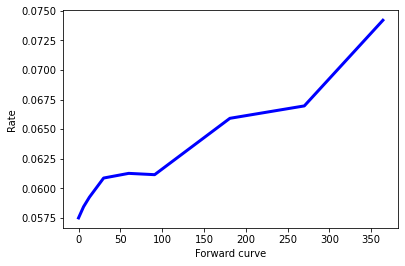

     fwd_rate
0    0.057500
1    0.057657
2    0.057815
3    0.057972
4    0.058130
..        ...
360  0.073903
361  0.073980
362  0.074057
363  0.074134
364  0.074212

[365 rows x 1 columns]


In [4]:
first_fwd = curve["Rates"][0]
forward_curve = pd.DataFrame(columns = ["fwd_rate"])
forward_curve.loc[0] = first_fwd

for i in range(1, len(curve)):
    fwd_days =  curve["Days"][i] - curve["Days"][i - 1]                          #6
    forward_rate = ((1 + curve["Rates"][i] * curve["Days"][i] / 365) / 
                (1 + curve["Rates"][i - 1] * curve["Days"][i - 1] / 365) - 1 ) * 365 / (
        curve["Days"][i] - curve["Days"][i - 1])                  # 1-7 rate
    first_fwd = forward_curve.iloc[-1][0]                                          # 0-1 rate
    rates = solver(fwd_days, first_fwd, forward_rate)                           # 1 - 7 rate
    forward_curve = forward_curve.append(pd.DataFrame(rates, columns = ["fwd_rate"]), ignore_index = True)

plt.plot(forward_curve["fwd_rate"], color = 'blue', linewidth = 3, linestyle='-')
plt.xlabel("Forward curve")
plt.ylabel("Rate")
plt.show()
print(forward_curve)

In [243]:
#Check
curve_check = []
for i in range(len(curve)):
    result = 1
    for j in range(curve["Days"][i]):
        result = result * (1 + forward_curve["fwd_rate"][j] / 365)
    curve_check.append(round((result - 1) * 365 / curve["Days"][i], 5))
curve_check

[0.0575, 0.058, 0.0585, 0.0595, 0.0605, 0.0615, 0.063, 0.065, 0.0675]